# Модуль А. Анализ и предобработка данных

## Импорт библиотек

In [18]:
# для преобразований фотографий
import cv2
from PIL import Image

# для работы с файловой системой
import os
import shutil

# модуль с более удобными словарями
from collections import defaultdict

# для разбиения на выборки
from sklearn.model_selection import train_test_split

# для визуализации
import matplotlib.pyplot as plt

# для работы с архивами
from zipfile import ZipFile

In [19]:
# получаем корневой путь
main_dir = os.getcwd()[:-8]
print("Текущая корневая директория:", main_dir)

Текущая корневая директория: d:\Helper\MLBazyak\chemp\face_recognitionV2


## Загрузка данных

в качестве данных, я получил архив с названием `Датасеты25.zip`. для начала работы, нужно их разархивировать.

Используя утилиту `WinRAR` я разархивировал папку `Датасеты25` в директорию `Data\`, а также переименовал папку на `Data25`, так как с русскими путями часто бывают проблемы. Папку для `MacOS` я решил не использовать

In [34]:
# путь к основной папке с данными
data_path = os.path.join(main_dir, r'Data\Data25')
# список всех представленных папок (датасетов)
datas_list = os.listdir(data_path)
# логирование
print(f'Папка с данными: {data_path}')
print(f'Всего предлагаемых датасетов: {len(datas_list)}')
print(f'Представленные папки: {datas_list}')

Папка с данными: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25
Всего предлагаемых датасетов: 3
Представленные папки: ['archive', 'archive-3', 'faces']


## Датасет 1: archive

In [35]:
# получаем путь к первому датасету (archive)
path_to_data1 = os.path.join(data_path, datas_list[0])
# логирование
print(f'Путь к первому датасету: {path_to_data1}')

Путь к первому датасету: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive


В датасете представлены `2` основные папки - просто с фотографиями с лицами, и с кропами лиц тех же самых фотографий 

In [45]:
print(os.listdir(path_to_data1)) # 2 основные папки, и файл с логами
# получааем путь к папке с кропами
extracted_face_data1 = os.path.join(path_to_data1, r'Extracted Faces\Extracted Faces')
print(f'Путь к папке с кропами: {extracted_face_data1}')
# получаем путь к папке с целыми фото
face_data1 = os.path.join(path_to_data1, r'Face Data\Face Dataset')
print(f'Путь к папке с целыми фото: {face_data1}')

['.DS_Store', 'Extracted Faces', 'Face Data']
Путь к папке с кропами: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive\Extracted Faces\Extracted Faces
Путь к папке с целыми фото: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive\Face Data\Face Dataset


проанализируем этот датасет:

Датасет с кропами: всего 1324 папок
Датасет с кропами: всего 6107 фотографий


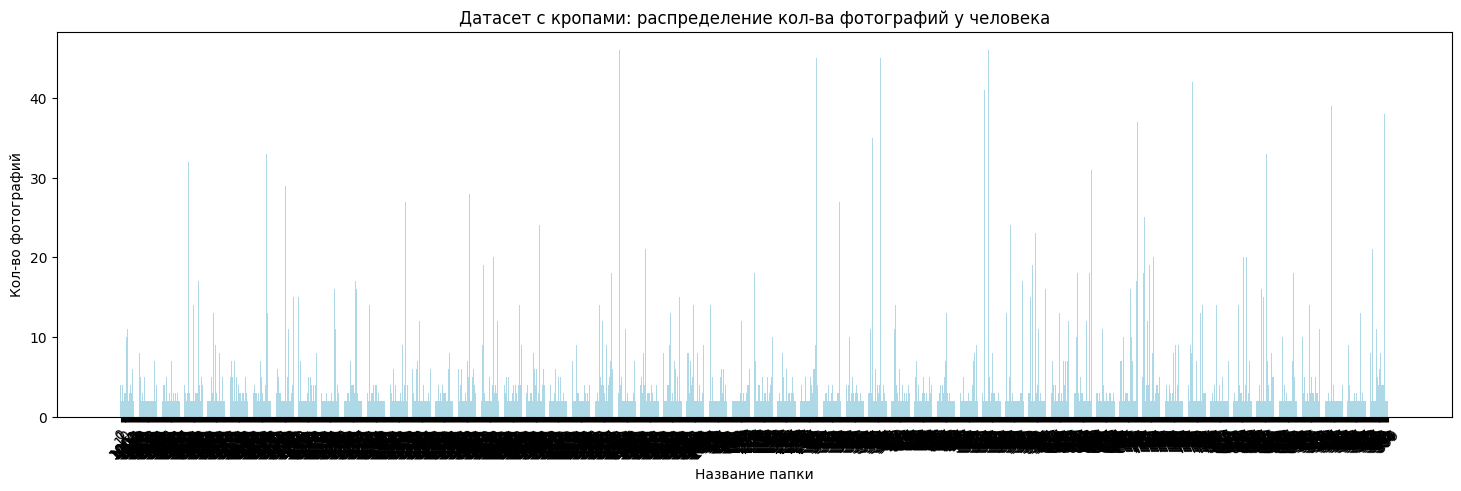

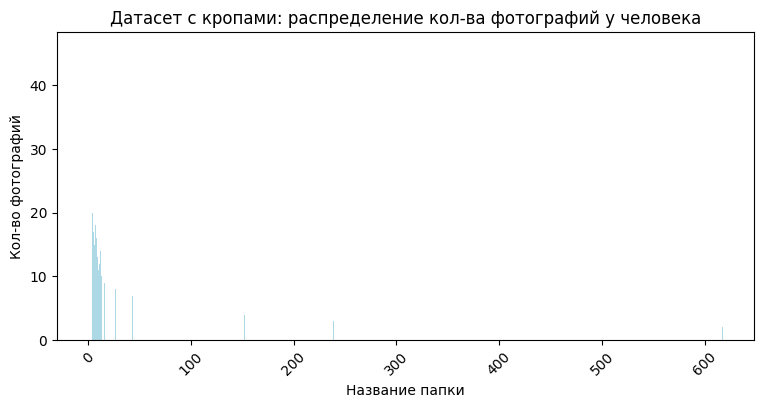

NameError: name 'name' is not defined

In [55]:
# список с именами датасетов
data_names = ['Датасет с кропами', 'Датасет с фотографиями']
datas = [extracted_face_data1, face_data1]

# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]
    # логирование
    print(f'{data_names[i]}: всего {len(os.listdir(datas[i]))} папок')
    # счетчик фотографий
    counter = 0
    # словарь для статистики
    nums_stats = defaultdict(int)
    value_stats = defaultdict(int)
    # проходимся по каждой папке 
    for folder in os.listdir(datas[i]):
        # получаем путь к папке
        folder_path = os.path.join(datas[i], folder)
        # обновляем счетчик и вводим статистику в словарь
        img_nums = len(os.listdir(folder_path))
        counter+=img_nums
        nums_stats[folder]+=img_nums
        value_stats[img_nums]+=1

    print(f'{data_names[i]}: всего {counter} фотографий')

    # парсим получившийся словарь
    nums = nums_stats.values()
    folders = nums_stats.keys()
    # визуализируем результат
    plt.figure(figsize=(18,5))
    plt.bar(folders, nums, color='lightblue')
    plt.title(f'{data_names[i]}: распределение кол-ва фотографий у человека')
    plt.xlabel('Название папки')
    plt.ylabel('Кол-во фотографий')
    plt.xticks(rotation=45)
    plt.show()

    # парсим получившийся словарь
    value = value_stats.values()
    counts = value_stats.keys()
    # визуализируем результат
    plt.figure(figsize=(9,4))
    plt.bar(value, counts, color='lightblue')
    plt.title(f'{data_names[i]}: распределение кол-ва фотографий у человека')
    plt.xlabel('Название папки')
    plt.ylabel('Кол-во фотографий')
    plt.xticks(rotation=45)
    plt.show()

    # максимальное значение и имя
    max_name, max_value = '', max(value)
    # смотрим у кого больше всего фотографий
    for i in range(len(value)):
        if value == max_value:
            print(folders[i])
            max_name = folders[i]

    print(f'Максимальное кол-во: {max_value}, имя - {name}')



**Структура данных в наборе:**

    -> archive\     # главная папка
        -> Extracted Faces\Extracted Faces\     # папка с кропнутыми лицами
            -> 0\       # "именная" папка
                -> 0.jpg        # фотография
                -> 1.jpg        # фотография
                
            -> 1\      
                -> 0.jpg
                -> 1.jpg

        -> Face Data\Face Dataset\      # папка с цельными лицами
            -> 0\       # "именная" папка
                -> 0.jpg        # фотография      
                -> 1.jpg        # фотография      

            -> 1\
                -> 0.jpg
                -> 1.jpg

